In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


CNN(Convolution_Neural_Newwork) - 합성곱 신경망

데이터 획득  
MNIST 손글씨 데이터를 내려받아 학습 데이터 및 테스트 데이터로 분리해서 저장한다.  
MNIST 손글씨 데이터는 28 * 28의 픽셀 데이터로 각 픽셀은 흑백 사진과 같이 0부터 255 사이의 그레이스케일을 가지고 있다.

In [2]:
# 6만개의 학습 데이터와 1만개의 테스트 데이터를 읽어들인다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

학습 데이터에서 검증 데이터 분리하기  
학습 중간마다 검증 데이터로 모델 성능을 측정하면 모델 학습이 제대로 진행되는지 검증 정확도를 알 수 있고 학습 정확도는 올라가는데 검증 정확도가 더 이상 올라가지 않거나 오히려 떨어질 경우 학습의 조기 종료를 구현할 수 있다.

In [3]:
# 6만개의 학습 데이터 중에서 1만개의 학습 데이터를 검증 데이터로 따로 저장한다.
x_val = x_train[50000:] # 학습 데이터 6만개 중에서 학습 결과 검증에 사용할 데이터 1만개
x_train = x_train[:50000] # 학습 데이터 6만개 중에서 학습에 사용할 데이터 5만개
y_val = y_train[50000:] # 검증 데이터 레이블
y_train = y_train[:50000] # 학습 데이터 레이블

In [4]:
print('학습 데이터: {}'.format(x_train.shape)) # 학습 데이터는 5만개 이고 28 * 28 픽셀의 이미지이다.
print('학습 데이터 레이블: {}'.format(y_train.shape))
print('검증 데이터: {}'.format(x_val.shape)) # 검증 데이터는 1만개 이고 28 * 28 픽셀의 이미지이다.
print('검증 데이터 레이블: {}'.format(y_val.shape))
print('테스트 데이터: {}'.format(x_test.shape)) # 테스트 데이터는 1만개 이고 28 * 28 픽셀의 이미지이다.
print('데스트 데이터 레이블: {}'.format(y_test.shape))

학습 데이터: (50000, 28, 28)
학습 데이터 레이블: (50000,)
검증 데이터: (10000, 28, 28)
검증 데이터 레이블: (10000,)
테스트 데이터: (10000, 28, 28)
데스트 데이터 레이블: (10000,)


학습 데이터를 출력해보면 데이터가 0부터 255사이의 숫자(그레이스케일)로 구성된 것을 확인할 수 있다.

In [5]:
print(y_train[:10])
for i in x_train[0]:
    for j in i:
        print('{:3d} '.format(j), end='')
    print()

[5 0 4 1 9 2 1 3 1 4]
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0 
  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0 
  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0 
  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   

컴퓨터 비전에서 많이 사용되는 딥러닝 모델인 CNN의 장점은 다층 퍼셉트론과 비교하면 쉽게 알 수 있다.

다층 퍼셉트론의 첫 번째 단점은 고유 이미의 생김새를 사용할 수 없다는 것이다.  
다층 퍼셉트론의 경우 데이터를 입력하기 위해서 2차원 평면에 있는 숫자 이미지를 1차원 배열로 변환해야 한다.  
1차원 배열로 변환된 이미지 데이터는 원라 고유 숫자 이미지를 떠올리기 쉽지 않다. 1차원으로 변환된 이미지 데이터를 입력으로 받은 다층 퍼셉트론의 경우, 고유 데이터가 2차원 평면에서 가지고 있던 지역 정보를 잃어버린 채로 학습을 시작한다.

두 번째 단점은 다층 퍼셉트론은 픽셀 하나 하나의 변화에 상당히 민감하다는 것이다.  
이미지의 생김새 정보를 사용할 수 없는 다층 퍼셉트론은 가지고 있는 정보가 픽셀 정보밖에 없기 때문에 한 두 개의 차이가 모델 예측에 큰 영향을 끼치게 된다.

세 번째 단점은 다층 퍼셉트론은 픽셀 한 두 개의 정보에도 민감하게 반응하기 때문에 상당히 많은 변수를 모델 안에 가지고 있다는 것이다. 이로 인해 모델의 크기를 크게 만들고, 학습 시간이 오래 걸리며, 자칫 잘못하면 과대 적합된 모델이 되기 쉽다.

생김새 정보 획득하기

<img src="./CNN.png" align="left" width="1200"/>

두 개의 비슷한 생김새의 숫자 2가 있을 때 전체 생김새는 달라도 머리와 꼬리 부분이 있고 머리와 꼬리를 이어주는 대각선이 있다면 단번에 숫자 2임을 판별할 수 있다.

CNN은 어떻게 특징을 찾아내는가?

<img src="./CNN2.png" align="left" width="1200"/>

위 그림에서 필터 또는 커널이라고 불리는 반투명한 네모 상자가 이미의 왼쪽 최상단에서 일정하게 이동하면서 오른쪽 최하단까지 이동한다. 이처럼 필터를 이동하는 기법을 스트라이드(stride)라고 한다.  
필터는 특징을 추출하기 위한 네모 상자이고 이 필터와 겹치는 이미지 부분을 수용 영역이라 부른다.

아래 그림에서 대각선 필터는 숫자 2로 부터 두 곳의 대각선 특징을 발견한다. 그러나 숫자 1에서는 대각선 특징을 발견하지 못한다.

<img src="./CNN3.png" align="left" width="600"/>

모든 딥러닝 모델이 그렇듯이 CNN 모델 역시 수학적인 모델이다. 필터가 어떻게 특징을 추출해내는지 알아보자.  
MNIST 숫자 데이터는 흑백 이미지로 각 픽셀은 0부터 255 사이의 값 중 하나를 가지고 있다. 픽셀 안의 숫자 0은 흰색을 의미하여 255는 검은색을 그리고 그 사이의 숫자는 흰색과 검은색 사이의 어떤 색(회색)을 의미한다.  
만약 이미지 안에 흰색과 검은색만 존재한다면 아래 그림과 같이 0과 255로만 구성되어 있을 것이다.

<img src="./CNN4.png" align="left" width="1000"/>

위 그림에서 알 수 있듯이 필터 안에는 특정한 숫자가 들어있고 필터와 이미지의 겹치는 부분마다 곱셈이 이루어지고 필터에 4개의 픽셀이 있다면 4개의 영역이 곱해지고 곱해진 값은 최종적으로 더해진다.  
최종값이 크다는 의미는 필터와 겹쳐진 부분이 많다는 의미이며 반대로 최종값이 작을 경우 필터와 겹쳐지는 부분이 적었다라고 해석을 할 수 있다.

CNN 모델 안에서 각 특성의 개수만큼 필터가 필요하다.  
보통 전반부에 존재하는 필터는 직선, 곡선 같은 기초적인 특성을 구별하기 위해 존재하고 후반부에 존재하는 필터는 동그라미, 세모 같은 조금 더 고차원의 특징을 구별하기 위해 존재한다.  
필터를 사용해서 모든 특징을 찾아낸 후, 이 특징들은 다중 퍼셉트론의 입력값으로 들어가서 필터로 부터 구별된 특징을 기반으로 숫자 분류를 진행한다.

<img src="./CNN5.png" align="left" width="800"/>

필터를 스트라이드를 통해 얻어진 행렬을 피쳐 맵(feature map)이라고 한다.  
피쳐 맵을 활성화 함수에 넣어 구현한 행렬을 액티베이션 맵(activation map)이라고 한다.

맥스 풀링(max pooling)은 지정된 영역에서 가장 큰 수치를 선택하고 나머지는 버린다.  
아래 그림은 2 * 2 필터에 스트라이드를 적용한 피쳐 맵에 맥스 풀링을 적용한 예이다.  
피쳐 맵의 크기가 줄어듬으로써 얻는 장점은 계산에 사용되는 파라미터의 개수가 줄어들어 계산 속도가 빨라지고 파라미터를 줄임으로써 모델의 분산을 줄이고 그에 따라 과대 적합의 가능성을 줄여준다.

<img src="./CNN6.png" align="left" width="450"/>

제로 패딩(zero padding)은 0으로 입력 행렬의 테두리를 감싸주는 기술이다.  
스트라이드를 통해 입력된 행렬보다 작아진 행렬이 출력되고 작아진 만큼 정보 손실이 발생되므로 제로 패딩을 통해 행렬의 크기를 크게 함으로써 스트라이드 이후에도 이미지 크기를 동일하게 유할 수 있다.

<img src="./CNN7.png" align="left" width="450"/>

제로 패딩으로 인해 스트라이드 할 공간이 더 많아졌다. 만약 필터 크기기 3 * 3이고 스트라이드를 1픽셀씩 할 경우 피쳐 맵은 5 * 5로 제로 패딩을 하기 전의 입력과 동일한 크기로 출력될 것이다.

데이터 구조 변경하기  
28 * 28 픽셀의 단색 이미지이므로 데이터의 형태를 28 * 28 * 1로 맞춰준다.

In [6]:
# CNN 모델에 입력하기 위해 데이터 셋을 생성한다.
x_train = np.reshape(x_train, [50000, 28, 28, 1])
print('x_train.shape: {}'.format(x_train.shape))
x_val = x_val.reshape(10000, 28, 28, 1)
print('x_val.shape: {}'.format(x_val.shape))
x_test = x_test.reshape(-1, 28, 28, 1)
print('x_test.shape: {}'.format(x_test.shape))

x_train.shape: (50000, 28, 28, 1)
x_val.shape: (10000, 28, 28, 1)
x_test.shape: (10000, 28, 28, 1)


데이터 정규화  
데이터 정규화는 학습 시간을 단축하고 더 나은 성능을 발휘하도록 도와준다.  
MNIST 데이터의 모든 값은 0부터 255 사이의 범위 안에 있으므로 255로 나눠줌으로써 모든 값을 0부터 1 사이의 값으로 정규화 한다.

In [7]:
x_train = x_train.astype(np.float32)
x_train /= 255
x_val = x_val.astype(np.float32)
x_val /= 255
x_test = x_test.astype(np.float32)
x_test /= 255

손실 함수에서 크로스 엔트로피를 계산하기 위해 레이블을 원-핫 인코딩으로 변경한다.

In [8]:
y_train = tf.keras.utils.to_categorical(y_train, 10) # 학습 데이터의 레이블에 원-핫 인코딩을 적용한다.
y_val = tf.keras.utils.to_categorical(y_val, 10) # 검증 데이터의 레이블에 원-핫 인코딩을 적용한다.
y_test = tf.keras.utils.to_categorical(y_test, 10) # 테스트 데이터의 레이블에 원-핫 인코딩을 적용한다.

tensorflow로 CNN 구현하기

<img src="./CNN8.png" align="left" width="1100"/>

In [9]:
# MNIST 데이터 형태 그대로 28 * 28의 포맷을 입력 데이터로 사용하고 레이블은 0에서 9 사이의 숫자이다.
x = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1]) # 학습 데이터(x_train)를 기억할 placeholder 선언한다.
y = tf.placeholder(dtype=tf.float32, shape=[None, 10]) # 학습 데이터의 레이블(y_train)을 기억할 placeholder 선언한다.

파라미터(가중치, 바이어스)의 초기값을 설정한다.

In [10]:
import matplotlib.pyplot as plt

In [11]:
# random_normal()와 truncated_normal() 메소드는 매우 비슷하게 작동하지만 큰 차이가 있다.
# 두 메소드 모두 정규 분포에 따른 랜덤한 값을 가져오는데 두 메소드의 가장 큰 차이는 truncated_normal() 메소드는
# 너무 작거나 너무 큰 값이 아닌 값으로 랜덤하게 가져온다.
# 머신러닝이나 딥러닝 작업 중 너무 큰 기울기(기울기 폭주) 값이나 너무 작은 기울기(기울기 소멸) 값이 들어오면
# 작동을 멈춰버리는 현상이 발행되는데 이를 해결하기 위한 방법으로 너무 크거나 너무 작은 값을 랜덤값으로 가져오지 않는
# truncated_normal() 메소드를 사용해서 난수를 발생시켜 사용한다.
n = 100000
A = tf.random_normal((n,))
B = tf.truncated_normal((n,))

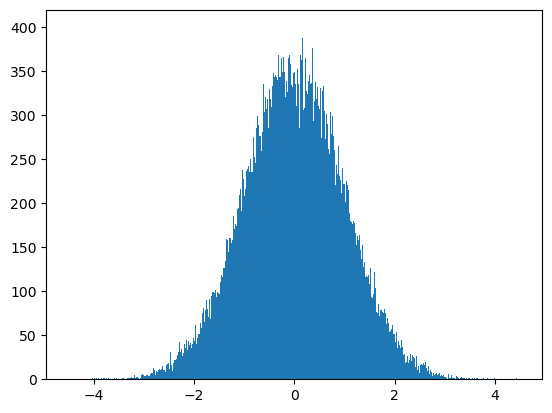

In [12]:
with tf.Session() as sess:
    a = sess.run(A)
    plt.hist(a, 1000, (-4.5, 4.5))

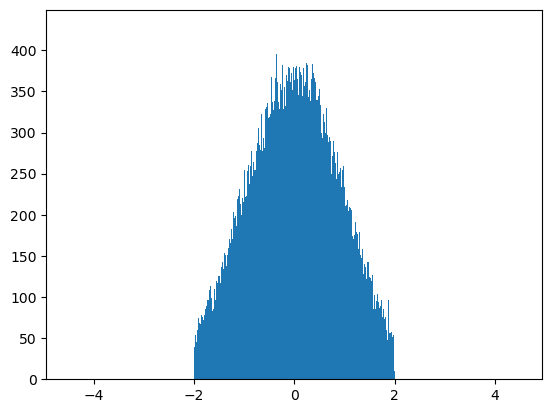

In [13]:
with tf.Session() as sess:
    b = sess.run(B)
    plt.hist(b, 1000, (-4.5, 4.5))

In [14]:
# truncated_normal() 메소드는 0에서 거리가 아주 먼 값이 설정되지 않게 도와준다.
# 0에서 거리가 먼 값을 제외시키는 이유는 소프트 맥스 안의 시그모이드 함수의 특성 때문인데 시그모이드 함수 같은 경우
# 입력값이 매우 크거나 작으면 그 미분값이 0과 가까워져서 경사 하강법으로 파라미터를 변경하기 어려워진다.

# 가중치를 만들어 리턴하는 함수
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1) # stddev 속성으로 난수가 발생되는 범위를 설정할 수 있다.
    return tf.Variable(initial)

# 바이어스를 만들어 리턴하는 함수
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [15]:
with tf.Session() as sess:
    w = weight_variable([2, 1])
    b = bias_variable([2])
    sess.run(tf.global_variables_initializer())
    print(sess.run(w), sess.run(b))

[[-0.04276853]
 [ 0.06156349]] [0.1 0.1]


In [16]:
# 필터를 적용할 이미지 데이터와 필터를 넘겨받아 컨볼루션 레이어를 만들어 리턴하는 함수
# conv2d(필터를 적용할 이미지 데이터, 필터, strides, padding) 메소드로 이미지 데이터에 필터를 스트라이드 만큼 적용한다.
# strides: 필터가 움직이는 간격으로 첫 번째 값과 네 번째 값은 통상적으로 1을 사용하고 두 번째 값은 가로 스트라이드 값,
#          세 번째 값은 세로 스트라이드 값을 입력한다.
# padding: 입력 데이터 행렬 주위를 무의미한 값(0)으로 감싸서 필터를 거쳐 나온 피쳐 맵의 크기가 작아지는 것을 방지하고
#          과대 적합이 발생하는 것을 방지할 수 있다.
#          => SAME: tensorflow가 자동으로 패딩을 적용해 입력값과 출력값의 크기를 같게한다. 패딩 적용
#          => VALID: tensorflow가 자동으로 패딩을 적용하지 않아 입력값 보다 출력값의 크기가 작아진다. 패딩 미적용
def conv2d(x, W_conv):
    return tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='SAME')

# 맥스 풀링을 적용할 데이터를 넘겨받아 맥스 풀링을 실행해서 리턴하는 함수
# max_pool(활성화 함수로 ReLu를 적용하고 맥스 풀링을 적용할 데이터, ksize, strides, padding) 메소드로 맥스 풀링을 적용한다.
# ksize: 맥스 풀링의 크기로 [1, 2, 2, 1]는 2 * 2 크기로 묶어서 맥스 풀링을 실행하라는 의미이다.
# strides, padding은 conv2d() 메소드와 의미가 같다.
# ksize, strides는 모두 필터의 크기를 의미하므로 동일한 값으로 지정해야 한다.
def max_pool_2x2(h_conv):
    return tf.nn.max_pool(h_conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [17]:
# 첫 번째 컨볼루션 레이어는 16개의 필터(출력)를 가지고 있고 필터 크기는 5 * 5이고 바이어스는 필터의 개수만큼 만든다.
# [필터의 가로 크기, 필터의 세로 크기, 입력의 개수, 필터(출력)의 개수]
W_conv1 = weight_variable([5, 5, 1, 16]) # 첫 번째 컨볼루션 레이어의 필터 정의
b_conv1 = bias_variable([16]) # 첫 번째 컨볼루션 레이어의 바이어스 정의

# 활성화 함수로 ReLu를 사용한다.
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)

# 첫 번째 컨볼루션 레이어의 출력에 맥스 풀링 레이어를 적용해서 액티베이션 맵의 크기를 줄여준다.
# 액티베이션 맵의 크기를 줄여줌으로써 파라미터가 줄어들어 모델의 크기가 작아지고 과대 적합의 위험도 감소시켜 준다.
h_pool1 = max_pool_2x2(h_conv1)
# 풀링 레이어에 의해 액티베이션 맵의 크기가 14 * 14가 되었고 이 값은 다음에 이어지는 두 번째 컨볼루션 레이어의
# 입력으로 들어간다.

In [18]:
# 두 번째 컨볼루션 레이어는 32개의 필터(출력)를 가지고 있고 필터 크기는 5 * 5이고 바이어스는 필터의 개수만큼 만든다.
W_conv2 = weight_variable([5, 5, 16, 32]) # 두 번째 컨볼루션 레이어의 필터 정의
b_conv2 = bias_variable([32]) # 두 번째 컨볼루션 레이어의 바이어스 정의
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
# 풀링 레이어에 의해 액티베이션 맵의 크기가 7 * 7이 되었고 이 값은 FC(Fully Connected Layer)의 입력으로 들어간다.

In [19]:
# FC(Fully Connected Layer)
# FC 영역에는 FC1, FC2 총 2개의 히든 레이어가 존재하고 FC1은 128개의 노드, FC2는 10개의 노드가 존재한다.
# FC2에 10개의 노드가 존재하는 이유는 FC2에 10개 노드의 값들을 소프트 맥스에 입력해서 각 노드별 확률을 구하기 위해서이다.
# 각 노드의 숫자는 0부터 9를 의미하며, 이 예측값은 크로스 엔트로피를 통해서 레이블과의 차이를 계산하는데 사용한다.

# FC는 컨볼루션 레이어를 통해 추출된 이미지의 특징을 입력받아 0부터 9 사이의 숫자 중 하나로 이미지를 분류한다.
W_fc1 = weight_variable([7 * 7 * 32, 128])
b_fc1 = bias_variable([128])

# 두 번째 컨볼루션 레이어의 맥스 풀링 결과를 행과 열을 변경해서 가중치와 행렬의 곱을 이용해 계산하고 활성화 함수로
# ReLu를 사용한다.
h_pool_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 32])
h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)

W_fc2 = weight_variable([128, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

손실 함수 정의

In [20]:
# 모델 정의가 끝났으므로 모델을 학습시키기 위해서 손실 함수를 정의한다. 손실 함수로는 크로스 엔트로피를 사용한다.
# 레이블과 예측값의 크로스 엔트로피를 설정한다.
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_conv, labels=y)
)

# Adam 옵티마이저를 사용해 모델을 최적화 한다.
train = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

정확도 계산

In [21]:
predict = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(predict, 'float'))

학습 시킨다.

In [22]:
# 미니 배치를 사용해서 모델을 최적화 한다.
# 하이퍼 파라미터 설정
epoch_cnt = 3
batch_size = 500
iteration = len(x_train) // batch_size

# 학습 시작
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epoch_cnt):
        start = 0
        end = batch_size
        
        for i in range(iteration):
            if (i + 1) % 10 == 0:
                train_acc = accuracy.eval(feed_dict={x: x_train[start:end], y: y_train[start:end]})
                print('epoch: {}, step: {:3d}, 학습 정확도: {:7.4f}'.format(epoch + 1, i + 1, train_acc))
            # ===== if
            # Adam 옵티마이저를 사용한 최적화 함수를 실행한다.
            train.run(feed_dict={x: x_train[start:end], y: y_train[start:end]})
            start += batch_size
            end += batch_size
        # ===== for i
        
        # 검증 데이터로 모델을 검증한다.
        val_accuracy = accuracy.eval(feed_dict={x: x_val, y: y_val})
        print('epoch: {}, 검증 정확도: {:7.4f}'.format(epoch + 1, val_accuracy))
        print('=' * 80)
    # ===== for epoch
    # 모델을 테스트 데이터로 테스트한 정확도를 계산해서 출력한다.
    test_accuracy = accuracy.eval(feed_dict={x: x_test, y: y_test})
    print('최종 모델 테스트 정확도: {:7.4f}'.format(test_accuracy))
# ===== with

epoch: 1, step:  10, 학습 정확도:  0.1820
epoch: 1, step:  20, 학습 정확도:  0.3640
epoch: 1, step:  30, 학습 정확도:  0.6640
epoch: 1, step:  40, 학습 정확도:  0.8700
epoch: 1, step:  50, 학습 정확도:  0.8740
epoch: 1, step:  60, 학습 정확도:  0.9320
epoch: 1, step:  70, 학습 정확도:  0.9240
epoch: 1, step:  80, 학습 정확도:  0.9420
epoch: 1, step:  90, 학습 정확도:  0.9520
epoch: 1, step: 100, 학습 정확도:  0.9340
epoch: 1, 검증 정확도:  0.9653
epoch: 2, step:  10, 학습 정확도:  0.9680
epoch: 2, step:  20, 학습 정확도:  0.9780
epoch: 2, step:  30, 학습 정확도:  0.9460
epoch: 2, step:  40, 학습 정확도:  0.9680
epoch: 2, step:  50, 학습 정확도:  0.9500
epoch: 2, step:  60, 학습 정확도:  0.9800
epoch: 2, step:  70, 학습 정확도:  0.9620
epoch: 2, step:  80, 학습 정확도:  0.9760
epoch: 2, step:  90, 학습 정확도:  0.9800
epoch: 2, step: 100, 학습 정확도:  0.9580
epoch: 2, 검증 정확도:  0.9764
epoch: 3, step:  10, 학습 정확도:  0.9880
epoch: 3, step:  20, 학습 정확도:  0.9840
epoch: 3, step:  30, 학습 정확도:  0.9700
epoch: 3, step:  40, 학습 정확도:  0.9880
epoch: 3, step:  50, 학습 정확도:  0.9800
epoch: 3, step:  60, 학습